<a href="https://colab.research.google.com/github/LanesG/colab/blob/master/CNN_Dog_Races_Randomized_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importieren der Libraries

In [0]:
!pip install --upgrade deeplearning2020

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from deeplearning2020 import helpers

In [0]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.\nGo to Runtime > Change runtime and select a GPU hardware accelerator.")

# Die Daten
## Laden der Daten

In [2]:
from deeplearning2020.datasets import ImageWoof

train_data, test_data, classes = ImageWoof.load_data()

/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


## Informationen über die Datensätze anzeigen
Die Bildpunkte sind als Floats zwischen 0 und 1 gespeichert.  
Die Labels der Daten liegen in sparse Form vor.

In [3]:
print("Trainingsdaten")
print(train_data)

print("Testdaten")
print(test_data)

print("Klassen")
print(classes)

Trainingsdaten
<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
Testdaten
<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
Klassen
['Shih-Tzu' 'Rhodesian ridgeback' 'Beagle' 'English foxhound'
 'Border terrier' 'Australian terrier' 'Golden retriever'
 'Old English sheepdog' 'Samoyed' 'Dingo']


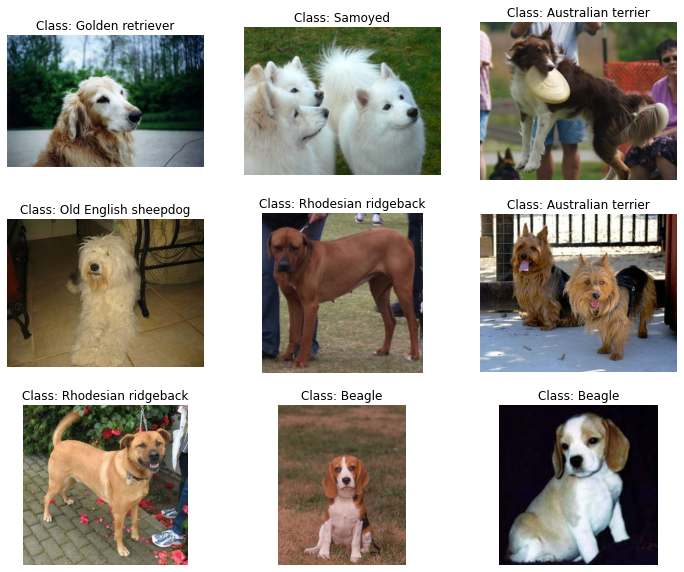

In [4]:
helpers.plot_images(train_data.take(9), classes)

## Preprocessing der Daten
Um mit den Bilddaten arbeiten zu können, müssen diese eine einheitliche Größe haben. Dafür steht die Funktion `preprocess` bereit, die alle Bilder in die vorgegebene Größe umwandelt.

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [300, 300])
    return resized_image, label

Anwendung der `preprocess` Funktion auf alle Daten.  
`.batch` bereitet den nächsten Batch mit festeglegter Größe vor.  
`.prefetch` lädt den nächsten Batch schon in den Speicher.

In [6]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 

train_data = train_data.shuffle(1000) 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data)

train_data = train_data.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess) \
  .batch(batch_size).prefetch(1)

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


In [7]:
# convert tf.dataset to numpy array
X, y, X_test, y_test = helpers.dataset_to_ndarray(train_data, test_data)

ResourceExhaustedError: ignored

# Das Netz

## Definition

In [0]:
def wrap_model(
    learning_rate=0.001, 
    momentum=0.9,
    decay=0.001, 
    dense_neurons=1000,
    n_filters=32,
    first_kernel_size=(7,7)
):

  activation='elu'

  # Inputgröße muss 300x300 Pixel mit 3 RGB Farben betragen
  input_layer = Input(shape=(300, 300, 3))

  model = Conv2D(
    filters=n_filters,
    kernel_size=(7,7),
    strides=(2,2),
    activation=activation,
    padding='same'
  )(input_layer)
  model = MaxPooling2D((2,2))(model)

  for i in range(2, 5):
    model = Conv2D(
      filters = i * n_filters, 
      kernel_size=(3,3), 
      activation=activation
    )(model)
    model = MaxPooling2D((2,2))(model)

  model = Conv2D(
    filters = 5 * n_filters,
    kernel_size=(3,3),
    activation=activation,
    padding='same'
  )(model)
  model = MaxPooling2D((2,2))(model)

  # Fully-Connected-Classifier
  model = Flatten()(model)
  model = Dense(
    dense_neurons,
    activation=activation
  )(model)

  model = Dense(
    dense_neurons / 2,
    activation='tanh'
  )(model)

  # Output Layer
  output = Dense(10, activation='softmax')(model)

  CNN_model = Model(input_layer, output)

  optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay)

  CNN_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
  )

  return CNN_model

In [0]:
CNN_model = wrap_model()
CNN_model.summary()

In [0]:
keras_regressor = tf.keras.wrappers.scikit_learn.KerasRegressor(wrap_model)

## Trainieren des Netzes

In [0]:
params_random = {
    'learning_rate':[0.0001, 0.001, 0.01], 
    'momentum':[0.9, 0.99, 0.999],
    'decay':[0.1, 0.01, 0.001, 0.0001], 
    'dense_neurons':[200, 500],# 1000, 2000],
    'n_filters':[16, 32, 64],
    'first_kernel_size':[(3,3), (5,5), (7,7)]
}

In [0]:
random_search = RandomizedSearchCV(keras_regressor, params_random, n_iter=20)
random_search.fit(X, y, epochs=20, validation_data=(X_test, y_test))

## Evaluieren des Netzes

In [0]:
print("Best sklearn-Score: ", random_search.best_score_)

In [0]:
print("Best Parameters: ", random_search.best_params_)

In [0]:
print("All results: ", random_search.cv_results_)

In [0]:
best_model = random_search.best_estimator_

In [0]:
eval_loss, eval_accuracy = best_model.evaluate(test_data)
print("Model accuracy: %.2f" % eval_accuracy)
print(eval_loss)